In [8]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2,3,4,5,6,7"

In [90]:
import torch
from transformers import AutoTokenizer
from trl import PPOTrainer, PPOConfig, AutoModelForCausalLMWithValueHead, create_reference_model
from trl.core import respond_to_batch

from pythainlp.corpus import thai_words
import pandas as pd
import numpy as np

In [10]:
device = torch.device("cuda") #ppo_trainer.accelerator.device
device

device(type='cuda')

## Tokenizer

In [12]:
import re

def has_thai_char(string):
    thai_char_regex = '[\u0E00-\u0E7F]+'
    return re.search(thai_char_regex, string) is not None

def has_english_char(string):
    english_char_regex = '[\x00-\x7F]+'
    return re.search(english_char_regex, string) is not None

In [74]:
tokenizer_xglm = AutoTokenizer.from_pretrained('facebook/xglm-564M')
tokenizer_gpt = AutoTokenizer.from_pretrained('sberbank-ai/mGPT') 
#'EleutherAI/gpt-neox-20b', EleutherAI/gpt-j-6B,'EleutherAI/gpt-neo-2.7B'

In [75]:
#% thai subwords; xglm
thai_toks = [i for i in tokenizer_xglm.vocab if has_thai_char(i)]
len(thai_toks), len(tokenizer_xglm.vocab), len(thai_toks) / len(tokenizer_xglm.vocab)

(4226, 256008, 0.016507296646979783)

In [76]:
#% eng subwords; xglm
eng_toks = [i for i in tokenizer_xglm.vocab if has_english_char(i)]
len(eng_toks), len(tokenizer_xglm.vocab), len(eng_toks) / len(tokenizer_xglm.vocab)

(143413, 256008, 0.5601895253273336)

In [78]:
#% thai subwords; gpt
thai_toks = [i for i in tokenizer_gpt.vocab if has_thai_char(i)]
len(thai_toks), len(tokenizer_gpt.vocab), len(thai_toks) / len(tokenizer_gptj.vocab)

(0, 100000, 0.0)

In [79]:
#% eng subwords; gpt
eng_toks = [i for i in tokenizer_gpt.vocab if has_english_char(i)]
len(eng_toks), len(tokenizer_gpt.vocab), len(eng_toks) / len(tokenizer_gpt.vocab)

(65524, 100000, 0.65524)

In [83]:
thai_words_df = pd.DataFrame({'thai_word': list(thai_words())})
thai_words_df['xglm_tokens'] = thai_words_df\
    .thai_word.map(lambda x: [tokenizer_xglm.decode(i) for i in tokenizer_xglm.encode(x)])
thai_words_df['xglm_nb_tokens'] = thai_words_df['xglm_tokens'].map(lambda x: len(x))
thai_words_df['gpt_tokens'] = thai_words_df\
    .thai_word.map(lambda x: [tokenizer_gpt.decode(i) for i in tokenizer_gpt.encode(x)])
thai_words_df['gpt_nb_tokens'] = thai_words_df['gpt_tokens'].map(lambda x: len(x))

In [84]:
thai_words_df.head(10)

,thai_word,xglm_tokens,xglm_nb_tokens,gpt_tokens,gpt_nb_tokens
0,นาฬิเก,"[</s>, , นา, ฬ, ิเ, ก]",6,"[น, า�, �, ิ, เก]",5
1,หน้าไม่อาย,"[</s>, หน้า, ไม่, อาย]",4,"[หน, ้, า, ไม, ่, อ, าย]",7
2,การหายใจเข้า,"[</s>, การ, หาย, ใจ, เข้า]",5,"[การ, ห, าย, ใจ, เข, ้, า]",7
3,มอนเทอเรย์,"[</s>, , มอน, เท, อเร, ย์]",6,"[ม, อน, เท, อเร, ย, ์]",6
4,ลดน้อยลง,"[</s>, ลด, น้อย, ลง]",4,"[ลด, น, ้, อย, ลง]",5
5,ปัญหาสังคม,"[</s>, , ปัญหา, สังคม]",4,"[ป, ั, ญ, ห, าส, ั, งค, ม]",8
6,กรมสมเด็จ,"[</s>, , กรม, สมเด็จ]",4,"[กรม, สมเด, ็, จ]",4
7,ตาทวด,"[</s>, ต, าท, วด]",4,"[ต, าท, วด]",3
8,ปุสสะ,"[</s>, ป, ุส, สะ]",4,"[ป, ุ, ส, สะ]",4
9,ตลก,"[</s>, ต, ลก]",3,"[ต, ล, ก]",3


<AxesSubplot:>

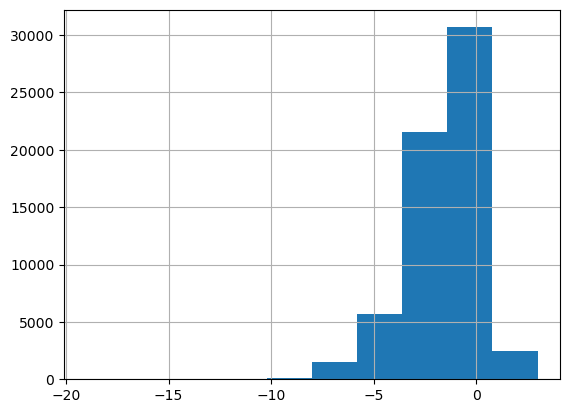

In [88]:
thai_words_df['diff_nb_tokens'] = thai_words_df.xglm_nb_tokens - 1 - thai_words_df.gpt_nb_tokens
thai_words_df.diff_nb_tokens.hist(bins=10)

In [91]:
#about 80% of the cases xglm tokenizes to fewer tokens
np.percentile(thai_words_df.diff_nb_tokens, np.arange(0, 100, 10))

array([-19.,  -4.,  -3.,  -2.,  -2.,  -1.,  -1.,  -1.,   0.,   0.])

In [93]:
from datasets import load_dataset

iapp = load_dataset('iapp_wiki_qa_squad')
iapp

Generating train split:   0%|          | 0/5761 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/742 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/739 [00:00<?, ? examples/s]

Dataset iapp_wiki_qa_squad downloaded and prepared to /home/charipol/.cache/huggingface/datasets/iapp_wiki_qa_squad/iapp_wiki_qa_squad/1.0.0/c1455d806e5a66ca9ee5c03b4aeaeaef4410afca6263c0bfb440ff1db28e20c3. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['question_id', 'article_id', 'title', 'context', 'question', 'answers'],
        num_rows: 5761
    })
    validation: Dataset({
        features: ['question_id', 'article_id', 'title', 'context', 'question', 'answers'],
        num_rows: 742
    })
    test: Dataset({
        features: ['question_id', 'article_id', 'title', 'context', 'question', 'answers'],
        num_rows: 739
    })
})

In [103]:
iapp['train'][0]['answers']['text'][0]

'3 ธันวาคม พ.ศ. 2533'

In [113]:
ds = []
for i in iapp['train']:
    ds.append({'concat': f"C: {i['context']} Q:{i['question']} A:{i['answers']['text'][0]}"})
iapp_df = pd.DataFrame(ds)
iapp_df['nb_tokens'] = iapp_df.concat.map(lambda x: len(tokenizer_xglm.encode(x)))

In [117]:
#90% is less than 573 tokens
np.percentile(iapp_df.nb_tokens, np.arange(0, 100, 10))

array([ 41., 106., 142., 179., 215., 255., 298., 346., 427., 563.])

In [118]:
(iapp_df.nb_tokens>512).mean(), iapp_df.shape

(0.12324249262280854, (5761, 2))

<AxesSubplot:>

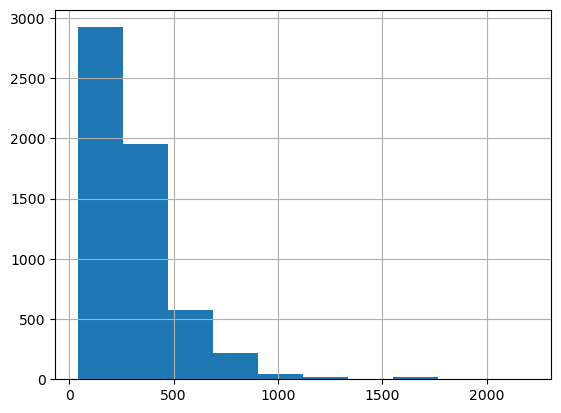

In [119]:
iapp_df['nb_tokens'].hist()

## Few-shot Inferences

In [121]:
pretrained = 'facebook/xglm-564M'
tokenizer = AutoTokenizer.from_pretrained(pretrained)
model = AutoModelForCausalLMWithValueHead.from_pretrained(pretrained).to(device)
model_ref = create_reference_model(model).to("cuda")

In [ ]:
# initialize trainer
ppo_config = PPOConfig(
    batch_size=1,
    forward_batch_size=1
)
ppo_trainer = PPOTrainer(ppo_config, model, model_ref, tokenizer)

In [167]:
# encode a query
query_txt = ["Q: ทีมไรเมพสุดในเกาะอังกฤษ A:" for i in range(10)]
query_tensor = tokenizer.encode(query_txt, return_tensors="pt").to(device)

# get model response
response_tensor  = respond_to_batch(model_ref, query_tensor,
                                   txt_len=512, top_k=0, top_p=1.,
                                   end=2)
tokenizer.decode(response_tensor[0])

'</s> Q: ทีมไรเมพสุดในเกาะอังกฤษ A: ฉันเลือกที่จะทํางานไฮโซบอนด์-ฮอร์นบิลแบธแมน-เมืองลอนดอน-ปาร์วินท์เบนด์ เฉลี่ยได้ 67.5 สําหรับการตัดแต่สตัดข้ามสามีของฉัน</s>'

In [192]:
# encode a query
query_txt = ["Q: ทีมไรเมพสุดในเกาะอังกฤษ A:" for i in range(10)]
query_tensor = tokenizer(text=query_txt, return_tensors="pt").to(device)

In [ ]:
%%time
response_tensor  = respond_to_batch(model_ref, query_tensor['input_ids'],
                                   txt_len=128, top_k=0, top_p=1.)

In [ ]:
tokenizer.batch_decode(response_tensor)